<a href="https://colab.research.google.com/github/dR3AmZZ/fifa-2020-analysis/blob/main/FIFA2020_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

## Data preprocessing

In [ ]:
# Load Data
%%bash
pip install pyspark
# Download the data files from github
# If the data file does not exist in the colab environment
if [[ ! -f ./players_20.csv ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
fi

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=04746b8c43f05910ab65634eba86e9cb738273b78ca931e85aa2c63ea7294250
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


--2020-11-30 03:17:48--  https://raw.githubusercontent.com/Kun97/FIFA20_DataAnalysis/main/players_20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8945067 (8.5M) [text/plain]
Saving to: ‘players_20.csv’

     0K .......... .......... .......... .......... ..........  0% 3.72M 2s
    50K .......... .......... .......... .......... ..........  1% 9.17M 2s
   100K .......... .......... .......... .......... ..........  1% 5.06M 2s
   150K .......... .......... .......... .......... ..........  2% 15.8M 1s
   200K .......... .......... .......... .......... ..........  2% 6.92M 1s
   250K .......... .......... .......... .......... ..........  3% 26.9M 1s
   300K .......... .......... .......... .......... ..........  4% 37.1M 1s
   350K .......... .......... .

In [ ]:
# The first code cell of your notebook shall include all needed imports to run your project code.  Note that
# there can be markdown cells above this cell.
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, lit, split, isnan, when, count, isnull
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel, StringIndexer, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [ ]:
original_data = spark.read.csv("players_20.csv", inferSchema=True, header=True)

In [ ]:
# drop useless columns
drop1_columns = ['sofifa_id', 'player_url', 'long_name', 'player_tags', 'player_traits', 'real_face', 'nation_jersey_number', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until','body_type']
fixed1_Data = original_data.drop(*drop1_columns)

In [ ]:
# drop position ability(duplicated and will affect the final result)
drop2_columns = fixed1_Data.columns[-26:]
fixed2_Data = fixed1_Data.drop(*drop2_columns)

In [ ]:
# drop duplicated columns
drop3_columns = ['wage_eur', 'team_position', 'release_clause_eur', 'nation_position', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
fixed3_Data = fixed2_Data.drop(*drop3_columns)

In [ ]:
# split player_positions and choose the first position as primary position
split_col = split(fixed3_Data['player_positions'], ',')
position_data = fixed3_Data.withColumn('Position', split_col.getItem(0))
position_data = position_data.drop('player_positions')

In [ ]:
# split work_Rate 
split_col = split(position_data['work_rate'], '/')
position_data = position_data.withColumn('Attack_workrate', split_col.getItem(0))
position_data = position_data.withColumn('Defend_workrate', split_col.getItem(1))
position_data = position_data.drop('work_rate')

In [ ]:
# narrow down positions: defender
defender = ['LCB', 'RCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']
defender_data = position_data.filter(col('Position').isin(defender)).withColumn('Positon_General', lit('Defender'))
defender_data.count()

5938

In [ ]:
# midfileder
midfileder = ['LCM', 'LM', 'RDM', 'CAM', 'RAM', 'RCM', 'CM', 'CDM', 'RM', 'LAM', 'LDM']
midfileder_data = position_data.filter(col('Position').isin(midfileder)).withColumn('Positon_General', lit('Midfileder'))
midfileder_data.count()

6862

In [ ]:
# attacker
attacker = ['ST', 'CF', 'LW', 'RW']
attacker_data = position_data.filter(col('Position').isin(attacker)).withColumn('Position_General', lit('Attacker'))
attacker_data.count()

3442

In [ ]:
# goal keeper
gk_data = position_data.filter(col('Position').isin(['GK'])).withColumn('Positon_General', lit('GK'))
gk_data.count()

2036

In [ ]:
general_data = defender_data.union(midfileder_data).union(attacker_data).union(gk_data)

In [ ]:
# missing values: 
general_data.select([count(when(isnull(c), c)).alias(c) for c in general_data.columns]).show()

+----------+---+---+---------+---------+-----------+----+-------+---------+---------+--------------+------------------------+---------+-----------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+--------------------+-----------------------+---------------------+----------------+-------------------+-------------------+-----------------+-------------------------+------------------------+------------------+--------------------+-------------------+-----------------------+--------------------+--------+---------------+---------------+---------------+
|short_name|age|dob|height_cm|weight_kg|nationality|club|overall|potential|value_eur|preferred_foot|international_reputation|weak_f

In [ ]:
# duplicated values: general data
if general_data.count() == general_data.drop_duplicates().count():
  print('No duplicated records.')

No duplicated records.


In [ ]:
# numerlize categorical data
# Rate: low, medium, high: 0, 1, 2
# foot: left, right: 1, 0
data_prepipe = Pipeline(stages=[
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Attack_workrate', outputCol='Attack_workrate_num'),
                                StringIndexerModel.from_labels(['Low', 'Medium', 'High'], inputCol='Defend_workrate', outputCol='Defend_workrate_num'),
                                StringIndexer(inputCols=["preferred_foot", "Positon_General"], outputCols=["preferred_foot_", "Positon_label"])
])

In [ ]:
general_data_xformed = data_prepipe.fit(general_data).transform(general_data)
general_data_xformed = general_data_xformed.drop('preferred_foot').\
                      withColumnRenamed('preferred_foot_','preferred_foot')

In [ ]:
#select numeric columns as features
feature_col = []
for cols,types in general_data_xformed.dtypes:
  if types in ['int','double']:
    feature_col.append(cols)
#remove target
feature_col.remove('value_eur')
feature_col.remove('Positon_label')
feature_col.remove('overall')
feature_col.remove('potential')

In [ ]:
#train test set split
train_set, test_set = general_data_xformed.randomSplit([0.7,0.3],seed = 0)

## Regression modle

In [ ]:
#skip time-consuming process grid search
Grid_search = False

### Linear regression

In [ ]:
#module import
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

In [ ]:
#define r square evaluator
r_square = RegressionEvaluator(labelCol='value_eur', metricName='r2')
#define mse evaluator
mse = RegressionEvaluator(labelCol='value_eur', metricName='mse')

#### Basic model training and evaluating

In [ ]:
#make linear regression pipeline and train the model
va = VectorAssembler(inputCols = feature_col,
                     outputCol = 'features')
lr = LinearRegression(featuresCol = 'features',
                      labelCol='value_eur',
                      predictionCol = 'prediction').\
                      setMaxIter(10)
LR_pipe = Pipeline(stages = [va,lr])
LR_pipe_fitted = LR_pipe.fit(train_set)
Predict_LR = LR_pipe_fitted.transform(test_set)

In [ ]:
#mse evaluator
lr_mse = mse.evaluate(Predict_LR)
#r^2 evaluator
lr_r2 = r_square.evaluate(Predict_LR)
print('basic model evaluation:\n ''mse:',lr_mse,'\n r2:',lr_r2)

basic model evaluation:
 mse: 12653485714529.701 
 r2: 0.5461485424578842


#### Elastic net regurlarization

In [ ]:
#add elastic net regularization to linear regression
elastic_net_alpha = np.arange(0,1,.3)
elastic_net_lambda = np.arange(.00,.90,.15)
#do grid search using each parameters
if Grid_search:
  grid = ParamGridBuilder()\
            .addGrid(lr.regParam, elastic_net_lambda ) \
            .addGrid(lr.elasticNetParam, elastic_net_alpha) \
            .build()
  cv = CrossValidator(estimator=LR_pipe,
                                  estimatorParamMaps=grid,
                                  evaluator=r_square,
                                  numFolds = 3,
                                  seed = 0)
  lr_cv = cv.fit(train_set)
  pass

In [ ]:
#extract hyperparameter of the best model
# MaxIter = lr_cv.bestModel.stages[-1].getMaxIter()
# ElasticNetParam = lr_cv.bestModel.stages[-1].getElasticNetParam()
# RegParam = lr_cv.bestModel.stages[-1].getRegParam()

In [ ]:
#hard coded the best model
RegParam = 0.75
ElasticNetParam = 0
MaxIter = 10
va = VectorAssembler(inputCols = feature_col,
                     outputCol = 'features')
lr = LinearRegression(featuresCol = 'features',
                      labelCol='value_eur',
                      predictionCol = 'prediction',
                      maxIter = MaxIter,
                      regParam = RegParam,
                      elasticNetParam = ElasticNetParam)
LR_pipe_best = Pipeline(stages = [va,lr])
LR_pipe_fitted_best = LR_pipe_best.fit(train_set)
Predict_best_LR = LR_pipe_fitted_best.transform(test_set)

In [ ]:
#mse of best model
test_mse_linear = mse.evaluate(Predict_best_LR)
#r2 of the best model
test_r2_linear = r_square.evaluate(Predict_best_LR)
print('Model after tuning evaluation:\n ''mse:',test_mse_linear,'\n r2:',test_r2_linear)

Model after tuning evaluation:
 mse: 12653485525336.783 
 r2: 0.5461485492437996


In [ ]:
coef = LR_pipe_fitted_best.stages[-1].coefficients
ipt = LR_pipe_fitted_best.stages[-1].intercept

#### Model performance result

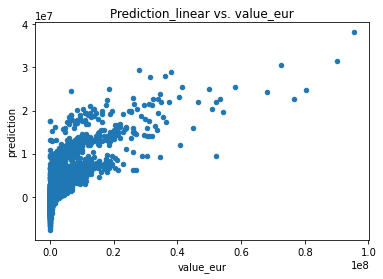

In [ ]:
#visualize prediction and value_eur to
Predict_best_LR.select('prediction', 'value_eur').toPandas().plot(x = 'value_eur', y = 'prediction', kind = 'scatter')
plt.title('Prediction_linear vs. value_eur')
plt.show()
#The model is strongly linear related

### Random Forest Regression

In [ ]:
#import module
from pyspark.ml.regression import RandomForestRegressor

#### Basic Model Training and evaluating

In [ ]:
#make and train randomforest regressor pipeline
rfr = RandomForestRegressor(featuresCol='features', labelCol = 'value_eur',
                            seed = 0)
rfr_pipe = Pipeline(stages=[va,rfr])
rfr_fitted = rfr_pipe.fit(train_set)

In [ ]:
#tranform
rfr_pred = rfr_fitted.transform(test_set)

In [ ]:
#mse of the model
rf_mse = mse.evaluate(rfr_pred)
#r2 of the best model
rf_r2 = r_square.evaluate(rfr_pred)
print('Basic model:\n ''mse:',rf_mse,'\n r2:',rf_r2)

Basic model:
 mse: 5379498261344.142 
 r2: 0.8070497583165716


#### Hyperparameter tuning

In [ ]:
if Grid_search:
  #do grid search to find best model
  rf = RandomForestRegressor().\
        setFeaturesCol('features').\
        setLabelCol('value_eur')
  rf_pipe = Pipeline(stages=[va, rf])
  #build parameters grid and cross validation model
  grid = ParamGridBuilder().\
            addGrid(rf.numTrees,[10,50,100]).\
            addGrid(rf.maxDepth,[10,20]).\
            addGrid(rf.minInstancesPerNode,[10,50]).\
            addGrid(rf.subsamplingRate,[0.1,0.2]).\
            build()
  rf_cv = CrossValidator(estimator=rf_pipe,
                        estimatorParamMaps = grid,
                        evaluator = mse,
                        numFolds=2,
                        seed = 0)
  rf_cv_fitted = rf_cv.fit(general_data_xformed)
  pass

In [ ]:
#extract hyperparameter of best model
# NumTrees = rf_cv_fitted.bestModel.stages[1].getNumTrees
# MinInstancesPerNode = rf_cv_fitted.bestModel.stages[1].getMinInstancesPerNode()
# MaxDepth = rf_cv_fitted.bestModel.stages[1].getMaxDepth()
# SubsamplingRate = rf_cv_fitted.bestModel.stages[1].getSubsamplingRate()

In [ ]:
#hard coded the best model
NumTrees = 100
MinInstancesPerNode = 10
MaxDepth = 20
SubsamplingRate = 0.2
#construct rf model with the best hyperparameter
rf = RandomForestRegressor(numTrees=NumTrees,
                           maxDepth = MaxDepth,
                           subsamplingRate = SubsamplingRate,
                           minInstancesPerNode = MinInstancesPerNode,
                           seed = 0).\
     setFeaturesCol('features').\
     setLabelCol('value_eur')
rf_bpipe = Pipeline(stages=[va, rf])
best_pipe = rf_bpipe.fit(train_set)

In [ ]:
#fit model with test data set
rfr_best_df = best_pipe.transform(test_set)

In [ ]:
#rmse of best randomforest model
test_mse_rf = mse.evaluate(rfr_best_df)
#r_square of the best randomforest
test_r2_rf = r_square.evaluate(rfr_best_df)
print('Model after tuning:\n ''mse:',test_mse_rf,'\n r2:',test_r2_rf)

Model after tuning:
 mse: 5938747336138.239 
 r2: 0.7869907790399814


#### Feature importance visualization

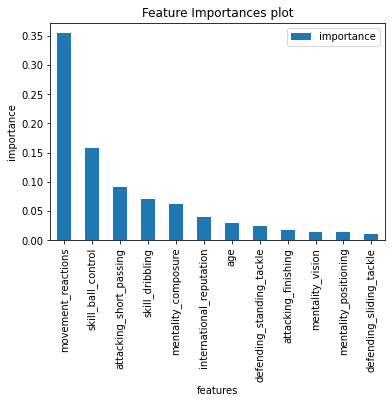

In [ ]:
#out put feature importances
featureImportances = pd.DataFrame(list(zip(feature_col, best_pipe.stages[-1].featureImportances)),
            columns = ['column', 'importance']).sort_values('importance', ascending = False)
featureImportances[featureImportances['importance'] > .01].plot(y='importance', x='column', kind = "bar" )
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature Importances plot')
plt.show()

### Gradient Boosting Machine Regression

#### Learning rate searching

In [ ]:
#import module
from pyspark.ml.regression import GBTRegressor

In [ ]:
#do a grid search
gbt = GBTRegressor(maxIter = 10, maxDepth = 4, seed = 0).\
      setFeaturesCol('features').\
      setLabelCol('value_eur')
gbt_pipe = Pipeline(stages=[va, gbt])
#build parameters grid and cross validation model 
#search for the best learning rate of GBM
train_r2 = []
test_r2 = []
stepsize = np.arange(0.1,0.9,0.1)
for step in stepsize:
  grid_gbt = ParamGridBuilder().\
          addGrid(gbt.stepSize,[step]).\
            build()
  gbt_cv = CrossValidator(estimator=gbt_pipe,
                        estimatorParamMaps = grid_gbt,
                        evaluator = mse,
                        numFolds=2,
                        seed = 0)
  gbt_cv_fitted = gbt_cv.fit(general_data_xformed)
  train_r2.append(r_square.evaluate(gbt_cv_fitted.bestModel.transform(train_set)))
  test_r2.append(r_square.evaluate(gbt_cv_fitted.bestModel.transform(test_set)))

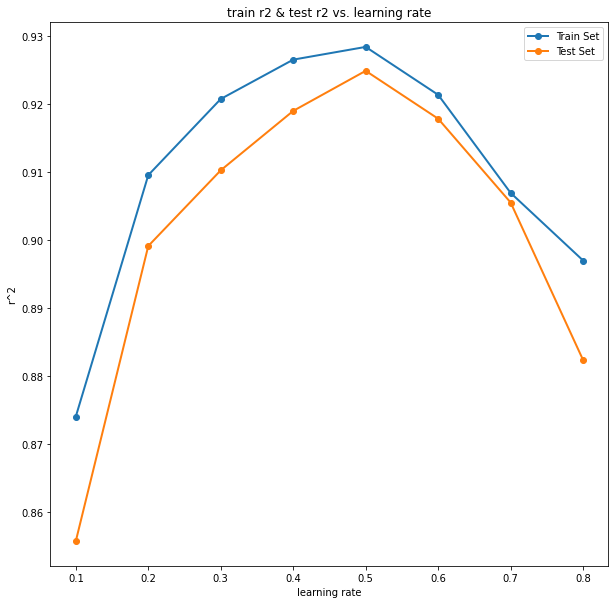

In [ ]:
#visualize train r2 & test r2 vs. learning rate
#learning rate - 0.5
plt.figure(figsize=(10,10))
plt.plot(stepsize, train_r2, 'o-', linewidth=2, label="Train Set")
plt.plot(stepsize, test_r2, 'o-', linewidth=2, label="Test Set")
plt.title('train r2 & test r2 vs. learning rate')
plt.xlabel("learning rate")
plt.ylabel("r^2")
plt.legend()
plt.show()

In [ ]:
#hard coded parameter best model code here
#CV model contains pipe model containing gbtregressor
gbt_best = GBTRegressor(maxDepth=10,
                        stepSize=0.5,
                        maxIter=4,
                        seed = 0).\
                        setFeaturesCol('features').\
                        setLabelCol('value_eur')
gbt_best_pipe = Pipeline(stages=[va, gbt_best])
gbt_best_fitted = gbt_best_pipe.fit(train_set)
gbt_test_df  = gbt_best_fitted.transform(test_set)
test_mse_gbt = round(mse.evaluate(gbt_test_df),2)
test_r2_gbt = round(r_square.evaluate(gbt_test_df),2)
print('Model after tuning:\n ''mse:',test_mse_gbt,'\n r2:',test_r2_gbt)

Model after tuning:
 mse: 7925517095656.42 
 r2: 0.72


### Linear model comparation

In [ ]:
#model comparation
compare_df = pd.DataFrame(list(zip(['LR',' RF','GBT'], [test_mse_linear, test_mse_rf, test_mse_gbt],
                                     [test_r2_linear, test_r2_rf, test_r2_gbt])),
            columns = ['model', 'mse','r^2'])
display(compare_df)

,model,mse,r^2
0,LR,1.265349e+13,0.546149
1,RF,5.938747e+12,0.786991
2,GBT,7.925517e+12,0.720000


## Classification modle

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#define auto f1 score evaluator
def f1_evaluation(model_pipeline, model_fitted, data):
  return MulticlassClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(), 
                                predictionCol=model_pipeline.getStages()[-1].getPredictionCol()).\
    evaluate(model_fitted.transform(data))
#define auto accuracy evaluator
def accuracy_evaluation(model_pipeline, model_fitted, data):
  return MulticlassClassificationEvaluator(labelCol=model_pipeline.getStages()[-1].getLabelCol(),
                                           metricName = 'accuracy', 
                                predictionCol=model_pipeline.getStages()[-1].getPredictionCol()).\
    evaluate(model_fitted.transform(data))
#define f1 multiclass evaluator
f1 = MulticlassClassificationEvaluator(labelCol='Positon_label', predictionCol='prediction')
#define accuracy multiclass evaluator
accuracy = MulticlassClassificationEvaluator(labelCol='Positon_label', predictionCol='prediction',
                                             metricName = 'accuracy')

### Multi-class logistic regression

In [ ]:
#import module
from pyspark.ml.classification import LogisticRegression

#### Basic model training and evaluating

In [ ]:
#train the model without hyperparametertuning 
lrc = LogisticRegression(maxIter=10).\
      setLabelCol('Positon_label')
lrc_pipe = Pipeline(stages=[va,lrc])
lrc_fitted = lrc_pipe.fit(train_set)
print('Basic model f1:')
lrc_f1 = f1_evaluation(lrc_pipe, lrc_fitted, test_set)
print(lrc_f1)
print('Basic model accuracy:')
lrc_acc = accuracy_evaluation(lrc_pipe, lrc_fitted, test_set)
print(lrc_acc)

Basic model f1:
0.7960171869417222
Basic model accuracy:
0.796078431372549


#### Elastic regularization and Grid search

In [ ]:
#add regularization to logistic regression
elastic_net_alpha = np.arange(0,1,.3)
elastic_net_lambda = np.arange(.00,.90,.15)\
#do grid search to find the best model
grid = ParamGridBuilder().\
            addGrid(lr.elasticNetParam,elastic_net_alpha).\
            addGrid(lr.regParam,elastic_net_lambda).\
            build()
cv = CrossValidator(estimator=lrc_pipe,
                        estimatorParamMaps = grid,
                        evaluator = f1,
                        numFolds = 3,
                        seed = 0)
lrc_cv = cv.fit(train_set)
pass

In [ ]:
#output hyperparameters
lrc_best = lrc_cv.bestModel
lmd = lrc_best.stages[-1].getElasticNetParam()
a = lrc_best.stages[-1].getRegParam()
print('lambda:',lmd,'\nalpha:',a)
#output f1 score
print('f1 after tuning:')
lrc_f1 = f1_evaluation(lrc_pipe, lrc_best, test_set)
print(lrc_f1)
print('Accuracy after tuning:')
lrc_accuracy = accuracy_evaluation(lrc_pipe, lrc_best, test_set)
print(lrc_accuracy)
#model performs the best when there is no regularization

lambda: 0.0 
alpha: 0.0
f1 after tuning:
0.7960171869417222
Accuracy after tuning:
0.796078431372549


#### Model performance evaluation

In [ ]:
#extract recall and precision by label from logisticregression summary
LRC_summary = lrc_best.stages[-1].summary
LRC_summary.accuracy
LRC_summary.recallByLabel
LRC_summary.precisionByLabel

[0.7432404540763674, 0.8351539225422046, 0.8057285180572852, 1.0]

In [ ]:
position_name = ['Midfileder','Defender','Attacker','GK']
#output recall by label
pd.DataFrame(list(zip(position_name, LRC_summary.recallByLabel)),
            columns = ['target_label', 'recall'])

,target_label,recall
0,Midfileder,0.763085
1,Defender,0.813543
2,Attacker,0.799423
3,GK,1.000000


In [ ]:
#output recall, precision, data table
#output precision by label
pd.DataFrame(list(zip(position_name, LRC_summary.precisionByLabel)),
            columns = ['target_label', 'precision'])

,target_label,precision
0,Midfileder,0.743240
1,Defender,0.835154
2,Attacker,0.805729
3,GK,1.000000


Seen that goal keeper player is different to other 3 kinds of players

### Random Forest classificition

In [ ]:
#import module
from pyspark.ml.classification import RandomForestClassifier

#### Basic Model training and evaluation

In [ ]:
#construct pipeline model
rfc = RandomForestClassifier(seed = 0).\
      setLabelCol('Positon_label')
rfc_pipe = Pipeline(stages=[va,rfc])
rfc_fitted = rfc_pipe.fit(train_set)

In [ ]:
#calculate accuracy
print('f1:')
rfc_acc = f1_evaluation(rfc_pipe, rfc_fitted, test_set)
print(rfc_acc)
print('Accuracy:')
rfc_acc = accuracy_evaluation(lrc_pipe, lrc_best, test_set)
print(rfc_acc)

f1:
0.838273254114523
Accuracy:
0.796078431372549


#### Hyperparameter tuning

In [ ]:
#do a grid search
if Grid_search:
  grid = ParamGridBuilder().\
            addGrid(rfc.numTrees,[10,50,100]).\
            addGrid(rfc.maxDepth,[10,20]).\
            addGrid(rfc.impurity,['gini','entropy']).\
            build()
  rfc_cv = CrossValidator(estimator=rfc_pipe,
                          estimatorParamMaps = grid,
                        evaluator = f1,
                        numFolds=2,
                        seed = 0)
  rfc_cv_fitted = rfc_cv.fit(general_data_xformed)
  pass

In [ ]:
#extract hyperparameter of best model
# NumTrees = rfc_cv_fitted.bestModel.stages[1].getNumTrees
# MaxDepth = rfc_cv_fitted.bestModel.stages[1].getMaxDepth()
# Impurity = rfc_cv_fitted.bestModel.stages[1].getImpurity()

In [ ]:
#Hard core hyperparameter
NumTrees = 100
MaxDepth = 20
Impurity = 'entropy'
print('NumTrees:',NumTrees,'\n MaxDepth:',MaxDepth ,'\n Impurity:', Impurity)
rfc_best = RandomForestClassifier(numTrees=NumTrees,
                           maxDepth = MaxDepth,
                           subsamplingRate = SubsamplingRate,
                           minInstancesPerNode = MinInstancesPerNode,
                           impurity = Impurity,
                           seed = 0).\
                            setFeaturesCol('features').\
                           setLabelCol('Positon_label')
rfc_bpipe = Pipeline(stages=[va, rfc_best])
rfc_best_pipe = rfc_bpipe.fit(train_set)

NumTrees: 100 
 MaxDepth: 20 
 Impurity: entropy


In [ ]:
#transform test_set
rfc_best_pipe.transform(test_set)
#calculate f1 score
print('f1 after tuning:')
rfc_best_f1 = f1_evaluation(rfc_pipe, rfc_best_pipe, test_set)
print(rfc_best_f1)
#calculate accuracy
print('Accuracy after tuning:')
rfc_best_acc = accuracy_evaluation(rfc_pipe, rfc_best_pipe, test_set)
print(rfc_best_acc)

f1 after tuning:
0.8844617010192888
Accuracy after tuning:
0.8848484848484849


#### Feature Importance visualization

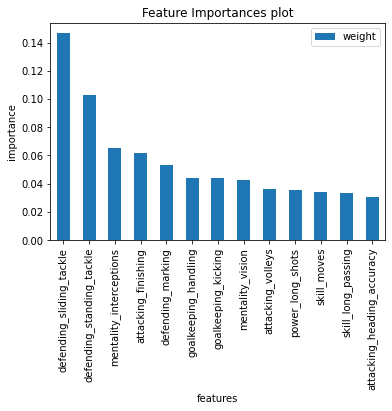

In [ ]:
#output feature imporatances
featureImportances = pd.DataFrame(list(zip(feature_col, rfc_best_pipe.stages[-1].featureImportances)),
            columns = ['column', 'weight']).sort_values('weight', ascending = False)
featureImportances[featureImportances['weight'] > .03].plot(y='weight', x='column', kind = "bar" )
plt.title('Feature Importances plot')
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

### Classification Model Comparation